In [1]:
import os
os.getcwd()
os.chdir("../")
os.getcwd()

'd:\\workspace\\git_projects\\NBFI-Loan-Repayment'

In [2]:
# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, 
confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc, classification_report)

from sklearn.model_selection import cross_val_score, GridSearchCV
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
from sklearn.metrics import make_scorer
from sklearn.utils import resample

from utils.dbmanager import create_sql_connection, ingest_data_to_sql, query_data

import random
random.seed(100)

import time
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
 
# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# mlflow
import mlflow
import mlflow.sklearn
from sqlalchemy import create_engine, text
import warnings
warnings.filterwarnings('ignore')

['SQL Server', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


In [3]:
server = 'nbfi-loan-def-prediction.database.windows.net'     
database = 'NBFIDB'  
username = 'adminuser'       
password = 'Rambo@12345' 

# Establish connection
conn = create_sql_connection(server, database, username, password)

Connection established successfully!


In [ ]:
data = query_data(conn, "SELECT * FROM Gold.CustomerRaw")
data.head(5)

In [29]:
data = pd.read_csv("data/interim/NBFIDataGold.csv")
data.shape

(121787, 49)

### Data Preprocessing

In [30]:
data.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Population_Region_Relative', 'Age_Days',
       'Employed_Days', 'Registration_Days', 'ID_Days', 'Own_House_Age',
       'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working', 'Client_Occupation',
       'Client_Family_Members', 'Client_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Score_Source_1', 'Score_Source_2', 'Score_Source_3',
       'Social_Circle_Default', 'Phone_Change', 'Credit_Bureau', 'Defaulters',
       'Debt_Income_Ratio', 'Annuity_Income_Ratio', 'Loan_Duration',
       'Age_Years', 'Employed_Years', 'Registration_Years', 'ID_Years',
       'Employment_to_Age_Ratio', 

In [31]:
# dropping unnecessary columns
data.drop(columns={'Own_House_Age', 'Score_Source_1', 'Social_Circle_Default', 'Client_Occupation','Population_Region_Relative',
                   'Child_Count', 'Client_Family_Members', 'Age_Days', 'Employed_Days', 'ID_Days',
                   'Registration_Days', 'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working'}, inplace=True)
data.shape

(121787, 35)

In [32]:
data.describe()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Credit_Amount,Loan_Annuity,Client_City_Rating,Application_Process_Day,Application_Process_Hour,Score_Source_2,Score_Source_3,Phone_Change,Credit_Bureau,Defaulters,Debt_Income_Ratio,Annuity_Income_Ratio,Loan_Duration,Age_Years,Employed_Years,Registration_Years,ID_Years,Employment_to_Age_Ratio,Credit_to_Age_Ratio,Family_Size
count,1.217870e+05,1.217870e+05,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000,121787.000000
mean,1.216093e+07,1.686508e+04,0.332770,0.322407,0.484305,0.701323,60044.941824,2721.245116,2.029478,3.156412,12.061181,0.518631,0.511190,955.853851,1.755581,0.080780,3.971628,0.181911,21.837388,43.396438,178.134842,13.104576,7.710125,3.102273,1471.472779,2.556710
std,3.517759e+04,1.136697e+04,0.471207,0.467400,0.499756,0.457680,39744.889817,1432.383543,0.499455,1.741600,3.231052,0.722962,0.171514,816.114541,1.744073,0.272499,2.683586,0.095317,8.775597,11.781950,376.146776,9.483085,4.039253,6.531790,1041.241752,1.564118
min,1.210000e+07,2.565000e+03,0.000000,0.000000,0.000000,0.000000,4500.000000,217.350000,1.000000,0.000000,0.000000,0.000005,0.000527,0.000000,0.000000,0.000000,0.037500,0.003850,1.653655,21.000000,0.000000,0.000000,0.000000,0.000000,67.164179,1.000000
25%,1.213046e+07,1.125000e+04,0.000000,0.000000,0.000000,0.000000,27450.000000,1687.500000,2.000000,2.000000,10.000000,0.402068,0.424130,287.000000,1.000000,0.000000,2.040667,0.115649,15.540384,34.000000,2.000000,5.000000,4.000000,0.057692,708.740217,2.000000
50%,1.216093e+07,1.575000e+04,0.000000,0.000000,0.000000,1.000000,52359.750000,2561.400000,2.000000,3.000000,12.000000,0.553179,0.511190,755.000000,1.000000,0.000000,3.312800,0.163925,20.000000,43.000000,6.000000,12.000000,8.000000,0.142857,1225.406976,2.000000
75%,1.219139e+07,2.025000e+04,1.000000,1.000000,1.000000,1.000000,80865.000000,3408.750000,2.000000,5.000000,14.000000,0.659828,0.631355,1550.000000,3.000000,0.000000,5.191578,0.230207,27.630389,53.000000,14.000000,20.000000,11.000000,0.341463,1968.810811,4.000000
max,1.222186e+07,1.800009e+06,1.000000,1.000000,1.000000,1.000000,405000.000000,22500.000000,3.000000,6.000000,23.000000,100.000000,0.896010,4185.000000,22.000000,1.000000,49.227200,1.570600,167.419328,69.000000,1000.000000,65.000000,19.000000,45.454545,11700.000000,30.000000


In [33]:
data = data[data["Score_Source_2"] <=1]
data.shape

(121781, 35)

In [34]:
data = data[data["Employed_Years"] <= 60]
data.shape

(100694, 35)

### Outlier Treatment

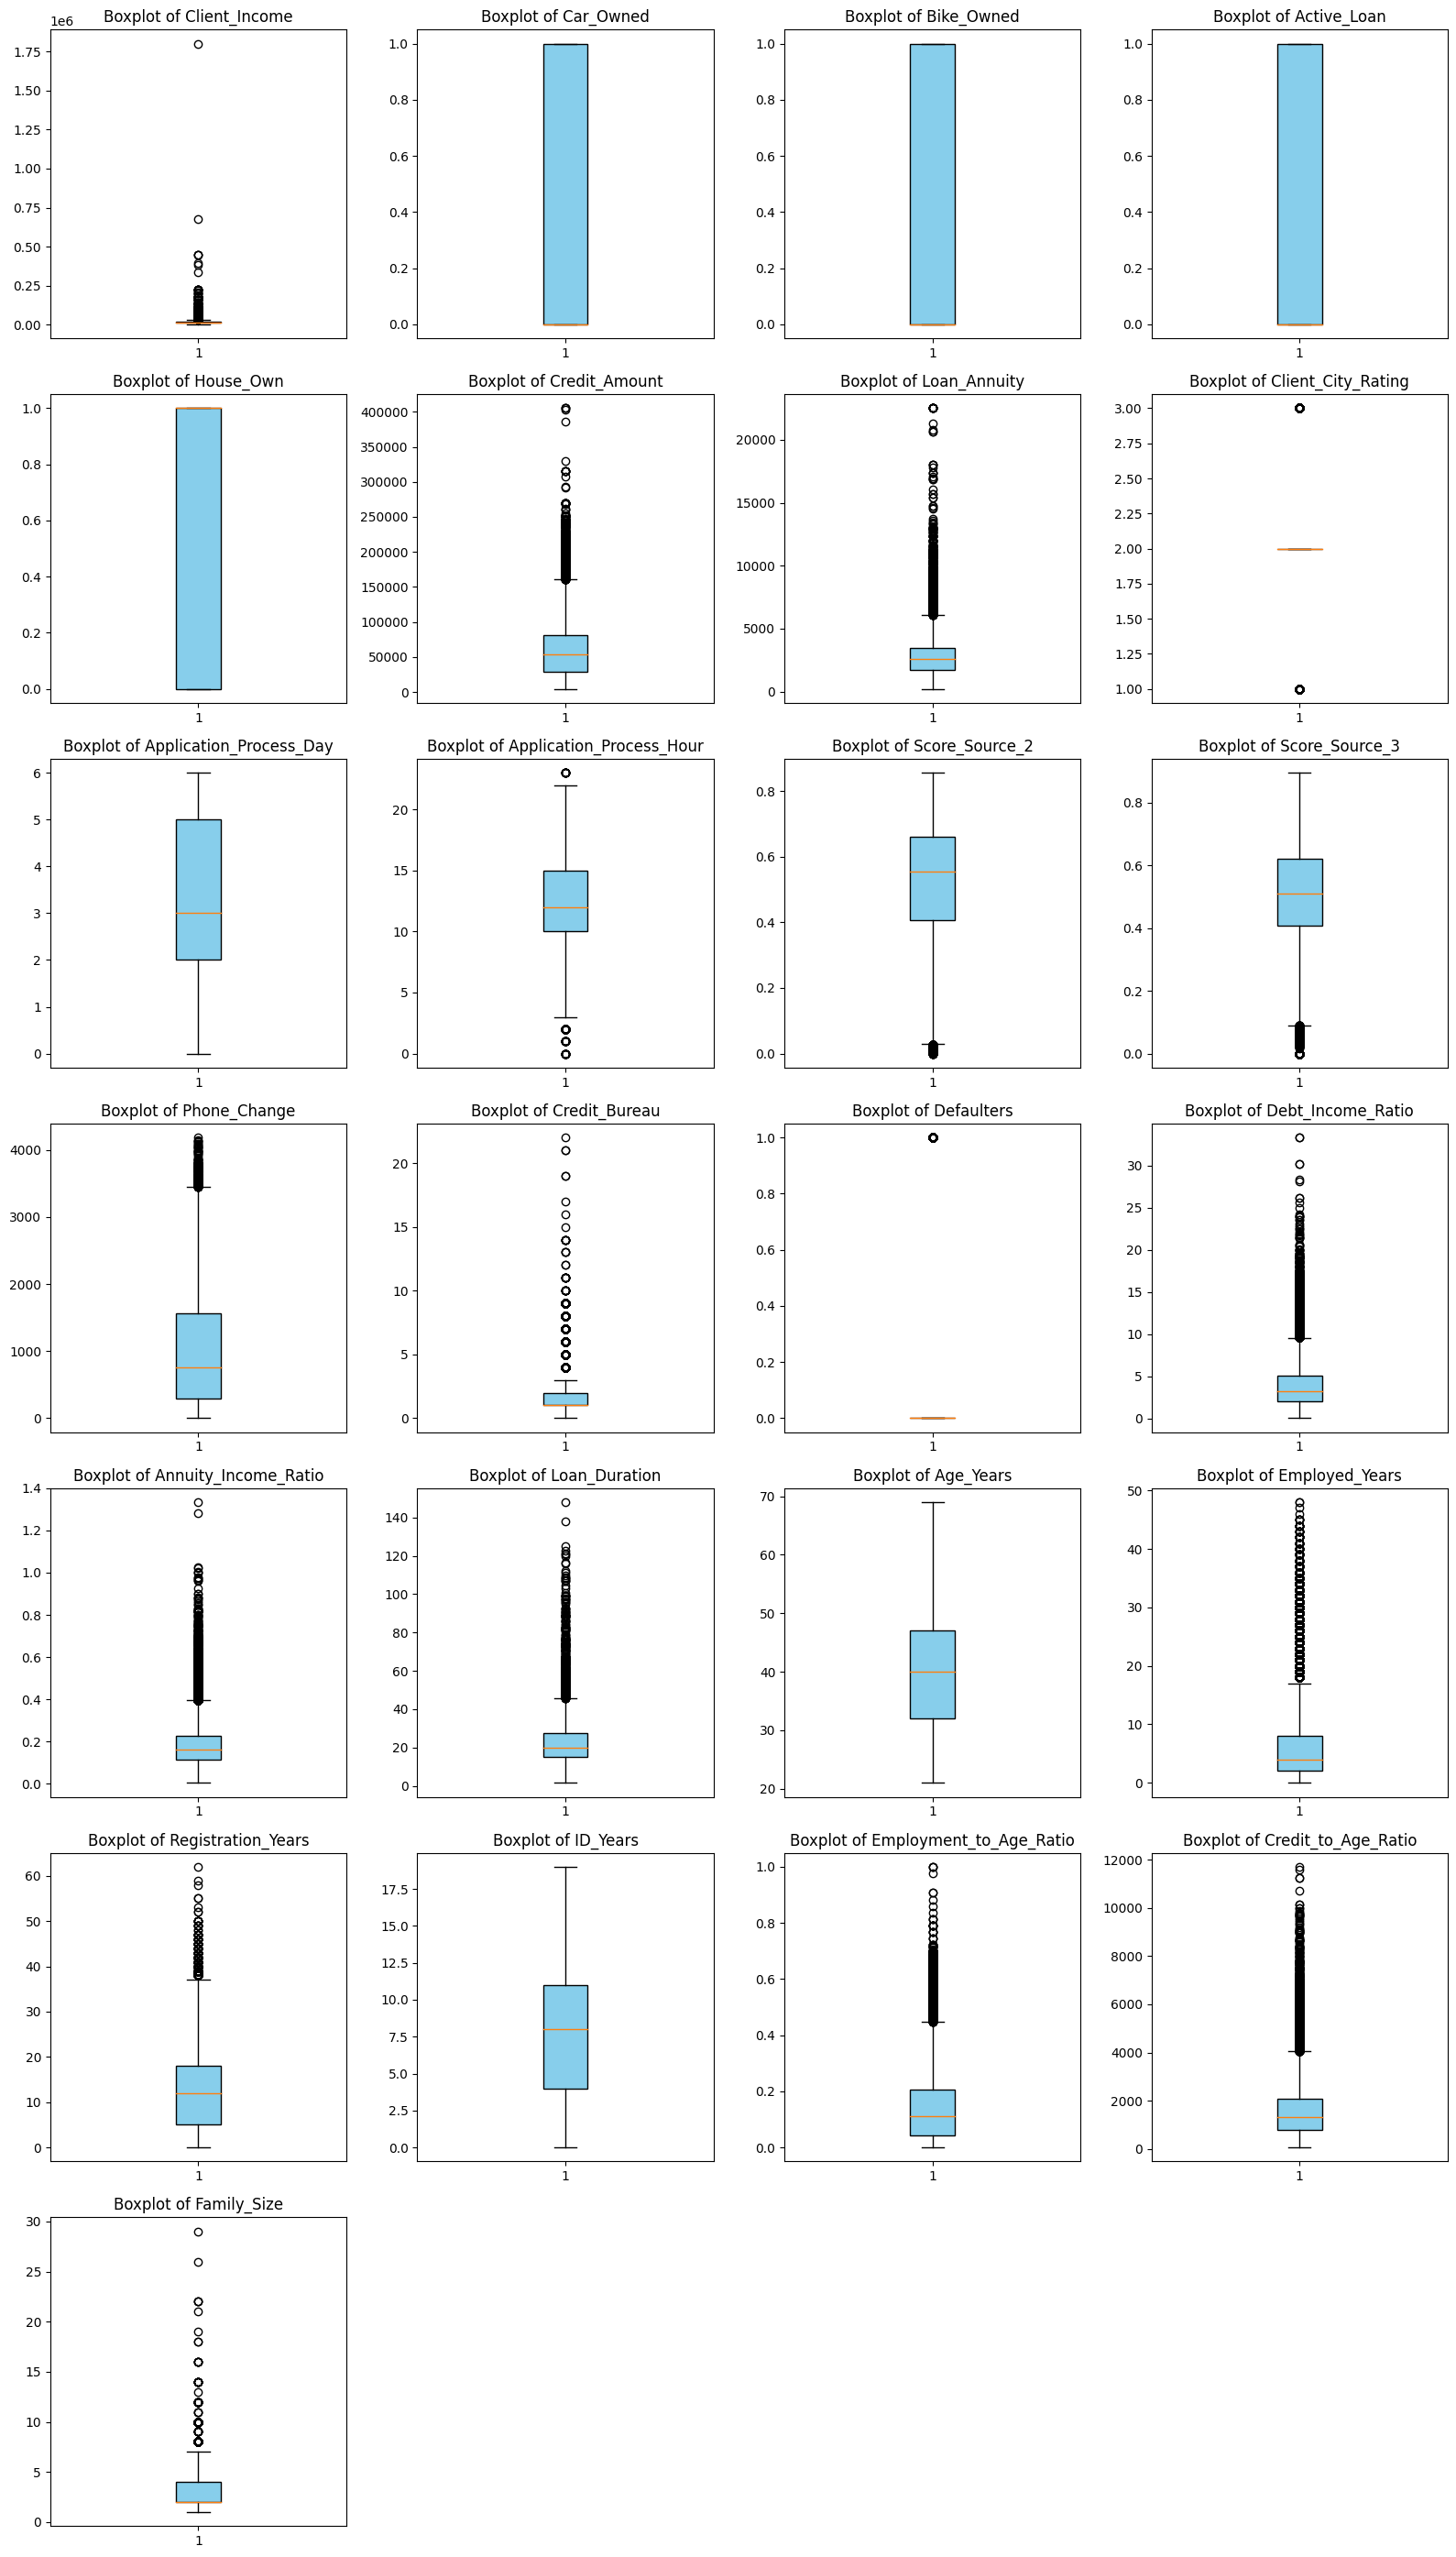

In [35]:
# Identify numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns[1:]  # Exclude 'ID' column
numeric_data = data[numeric_cols]  # Subset numeric data

# Set up the grid layout for multiple boxplots
num_cols = len(numeric_cols)
rows = (num_cols // 4) + (num_cols % 4 > 0)  # Arrange in 4 columns

plt.figure(figsize=(16, rows * 4))  # Adjust figure size dynamically

# Plot boxplots for each numeric variable
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 4, i)  # Define subplot grid
    plt.boxplot(numeric_data[col].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {col}")

plt.tight_layout()  # Adjust layout for better visualization
plt.show()

In [9]:
def treat_outliers_iqr(df, column):
    """
    Treat outliers in a specified column using the IQR method.
    Values outside the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR] are capped.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The column name to treat outliers.
    
    Returns:
        pd.Series: The column with outliers capped.
    """
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    return df[column].apply(
        lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
    )

In [36]:
data.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Credit_Amount', 'Loan_Annuity', 'Accompany_Client',
       'Client_Income_Type', 'Client_Education', 'Client_Marital_Status',
       'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type',
       'Client_City_Rating', 'Application_Process_Day',
       'Application_Process_Hour', 'Client_Permanent_Match_Tag',
       'Client_Contact_Work_Tag', 'Score_Source_2', 'Score_Source_3',
       'Phone_Change', 'Credit_Bureau', 'Defaulters', 'Debt_Income_Ratio',
       'Annuity_Income_Ratio', 'Loan_Duration', 'Age_Years', 'Employed_Years',
       'Registration_Years', 'ID_Years', 'Employment_to_Age_Ratio',
       'Credit_to_Age_Ratio', 'Family_Size'],
      dtype='object')

In [39]:
# Columns to treat
columns_to_treat = ["Client_Income", "Credit_Amount", "Loan_Annuity", "Credit_Bureau",
                    "Debt_Income_Ratio","Annuity_Income_Ratio", "Loan_Duration","Employed_Years", "Registration_Years",
                    "Phone_Change", "Score_Source_3", "Employment_to_Age_Ratio",
                    "Credit_to_Age_Ratio", "Family_Size"]

# Apply IQR-based outlier treatment
for col in columns_to_treat:
    data[col] = treat_outliers_iqr(data, col)

### Correlation Matrix

In [47]:
numerical_columns = data.select_dtypes(include=['number']).columns

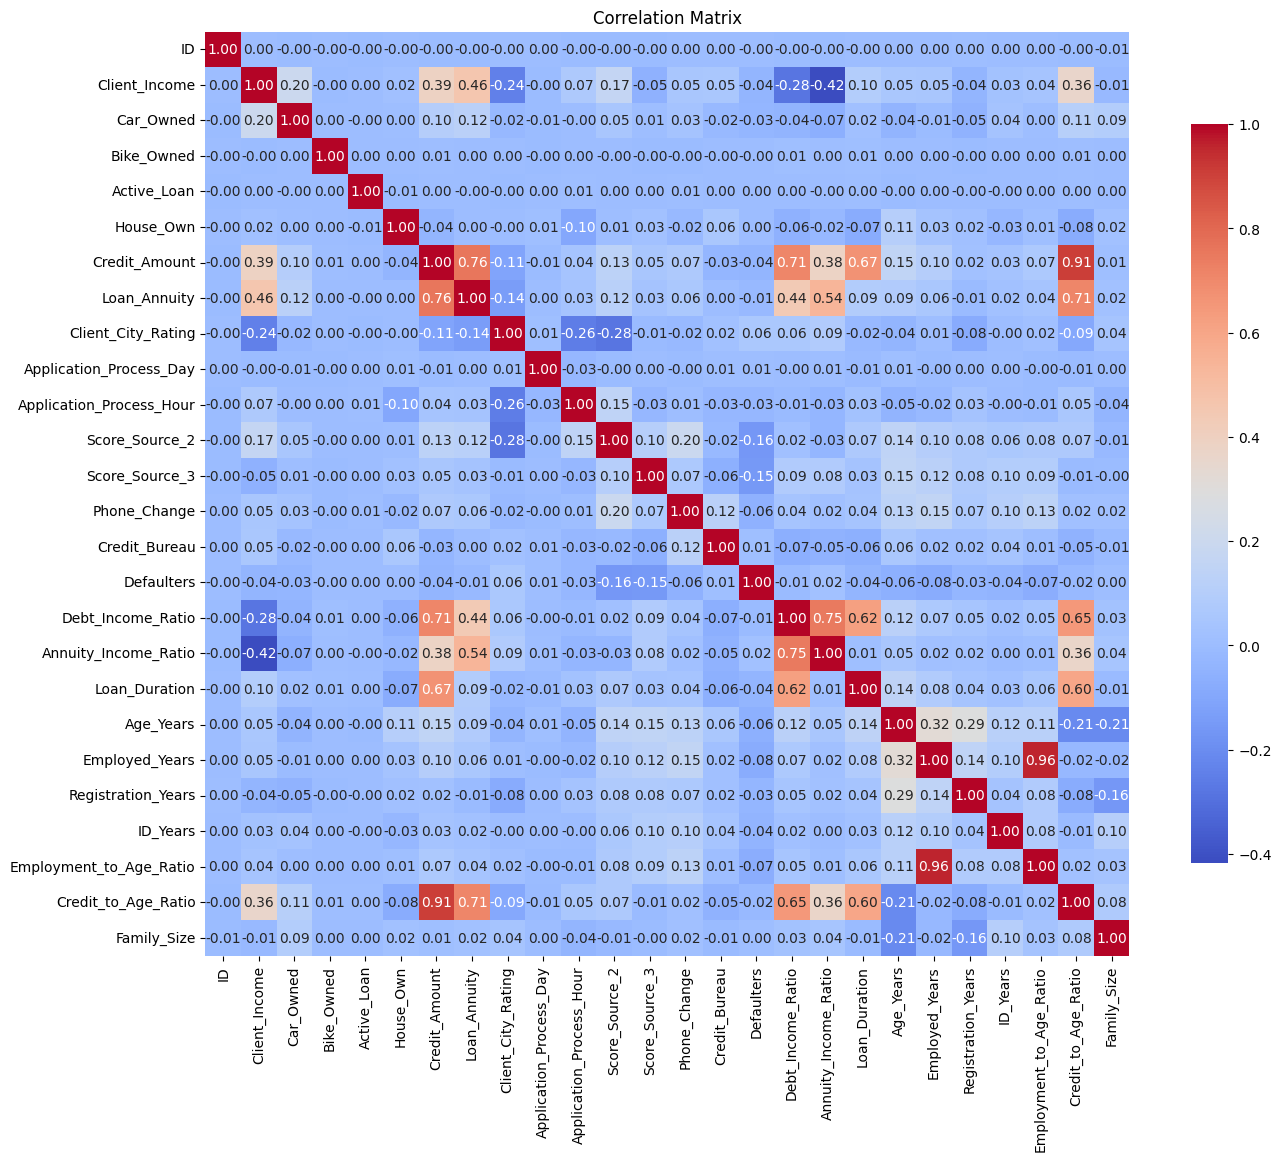

In [48]:
data[numerical_columns].corr()
# Plotting the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(data[numerical_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.show()


In [52]:
data['Defaulters'].value_counts(normalize=True)

Defaulters
0    0.913878
1    0.086122
Name: proportion, dtype: float64

### Undersampling

In [112]:
# Step 1: Separate majority and minority classes
data_majority = data[data['Defaulters'] == 0]
data_minority = data[data['Defaulters'] == 1]

# Step 2: Define the percentage for undersampling (e.g., 40%)
undersample_percent = 0.5  # Retain 50% of majority class

# Calculate the number of records to keep from the majority class
n_majority_to_keep = int(len(data_majority) * undersample_percent)
print(n_majority_to_keep)

46011


In [113]:

# Step 3: Downsample the majority class
data_majority_downsampled = resample(
    data_majority,
    replace=False,  # Sample without replacement
    n_samples=n_majority_to_keep,  # Retain only the specified percentage
    random_state=42  # For reproducibility
)

# Step 4: Combine the downsampled majority class with the minority class
data_balanced = pd.concat([data_majority_downsampled, data_minority])

# Step 5: Shuffle the combined dataset
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 6: Check the new class distribution
print("Class distribution after percentage-based undersampling:\n", data_balanced['Defaulters'].value_counts())

Class distribution after percentage-based undersampling:
 Defaulters
0    46011
1     8672
Name: count, dtype: int64


### Scaling & Train Test Split

In [114]:
cols_to_drop = ["ID_Years", "Application_Process_Hour", "Application_Process_Day", "Credit_to_Age_Ratio",
 "Registration_Years", "Credit_Bureau", "Client_Contact_Work_Tag", "Accompany_Client",
 "Debt_Income_Ratio", "Loan_Annuity", "Bike_Owned", "Family_Size", "Client_Income"]
data_balanced.drop(columns=cols_to_drop, inplace=True)

In [115]:
# Separate features and target
X = data_balanced.drop(columns=['Defaulters'])
y = data_balanced['Defaulters']

In [116]:
# Step 2: Encode categorical variables using One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)  # Convert categorical features to numerical

# Step 3: Train-Test Split (80-20 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train shape: (43746, 32)
X_test shape: (10937, 32)
y_train: (43746,)
y_test: (10937,)


In [117]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Base Model

In [118]:
random.seed(42)

model = LogisticRegression(penalty='l1', C=0.01, max_iter=500, class_weight='balanced', solver='liblinear', random_state=42)

model.fit(X_train_scaled, y_train)

# Step 7: Make Predictions
y_pred = model.predict(X_test_scaled)
# y_pred = y_pred.astype(int)

In [119]:
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)
# Step 8: Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

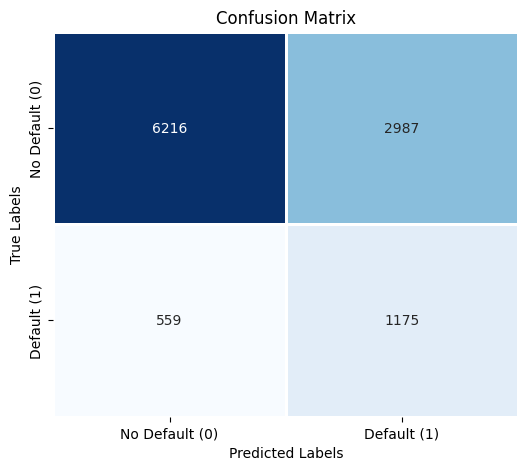

In [120]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=2, cbar=False, xticklabels=["No Default (0)", "Default (1)"], yticklabels=["No Default (0)", "Default (1)"])

# Formatting
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [121]:

print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

Model Accuracy: 0.6758

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.68      0.78      9203
           1       0.28      0.68      0.40      1734

    accuracy                           0.68     10937
   macro avg       0.60      0.68      0.59     10937
weighted avg       0.82      0.68      0.72     10937


Confusion Matrix:
 [[6216 2987]
 [ 559 1175]]


In [122]:
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Compute Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])  # Using probability scores

# Print Evaluation Metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Precision: 0.2823
Recall: 0.6776
F1 Score: 0.3986
ROC-AUC Score: 0.7337


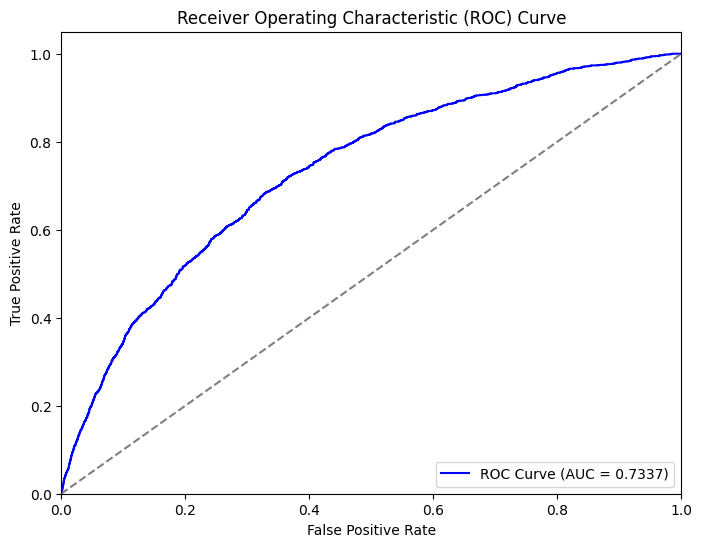

In [123]:
# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [124]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(model.coef_[0])  # Absolute values of coefficients
}).sort_values(by='Importance', ascending=False)

In [125]:
feature_importance

,Feature,Importance
7,Score_Source_3,0.464891
6,Score_Source_2,0.381404
20,Client_Education_Secondary,0.218424
24,Client_Gender_Male,0.164806
12,Employed_Years,0.135762
1,Car_Owned,0.108085
25,Loan_Contract_Type_RL,0.095033
9,Annuity_Income_Ratio,0.093158
5,Client_City_Rating,0.086016
19,Client_Education_Junior secondary,0.056666


In [128]:
data_balanced.columns

Index(['ID', 'Car_Owned', 'Active_Loan', 'House_Own', 'Credit_Amount',
       'Client_Income_Type', 'Client_Education', 'Client_Marital_Status',
       'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type',
       'Client_City_Rating', 'Client_Permanent_Match_Tag', 'Score_Source_2',
       'Score_Source_3', 'Phone_Change', 'Defaulters', 'Annuity_Income_Ratio',
       'Loan_Duration', 'Age_Years', 'Employed_Years',
       'Employment_to_Age_Ratio'],
      dtype='object')

In [ ]:
import pickle

# Example: Assume `model` is your trained model
with open("model/logistic_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("Model saved as 'logistic_model.pkl'")


Model saved as 'model.pkl'
